In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import sqlite3
import sys
import os
sys.path.append('/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/cascade model')
#os.chdir('/home/jif564/bancpipeline/analysis/python/')
import cascade_model
#from cascade_model import SignalCascade
#import igraph as ig
import pickle
import random
import json
import math

### Load frankenbrain and functions

In [2]:
def load_sqlite_database(sql_path):
    """
    Load metadata and connectivity data from SQLite database.
    
    Parameters:
    -----------
    sql_path : str
        Path to SQLite database
        
    Returns:
    --------
    tuple
        (metadata_df, edgelist_df, synapses_df)
    """
    conn = sqlite3.connect(sql_path)
    
    # List all tables (for verification)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("Tables in the database:", tables)
    
    # Load all tables
    meta_df = pd.read_sql_query("SELECT * FROM meta", conn)
    try:
        edgelist_df = pd.read_sql_query("SELECT * FROM edgelist_simple", conn)
    except Exception as e:
        print("Failed to load 'edgelist_simple'. Error:", e)
        print("Attempting to load 'edgelist' instead.")
        edgelist_df = pd.read_sql_query("SELECT * FROM edgelist", conn)
    #synapses_df = pd.read_sql_query("SELECT * FROM synapses", conn)
    
    conn.close()
    return meta_df, edgelist_df


def construct_connectivity_matrix(edgelist):
    # Get unique nodes from 'pre' and 'post' columns
    nodes = pd.Index(edgelist['pre']).union(edgelist['post'])
    
    # Create a mapping of node labels to matrix indices
    node_to_index = {node: i for i, node in enumerate(nodes)}
    
    # Initialize an empty matrix with zeros
    connectivity_matrix = np.zeros((len(nodes), len(nodes)), dtype=int)
    
    # Populate the matrix with 'synaptic_count' values
    for _, row in edgelist.iterrows():
        pre_index = node_to_index[row['pre']]
        post_index = node_to_index[row['post']]
        connectivity_matrix[pre_index, post_index] += row['synaptic_count']
    
    # Convert to DataFrame for easier interpretation with node labels
    connectivity_df = pd.DataFrame(connectivity_matrix, index=nodes, columns=nodes)
    return connectivity_df


In [3]:
#sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/frankenbrain_v.1.6_data.sqlite'
sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/banc_496_data.sqlite'
# O2
#sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/frankenbrain_v.1.6_data.sqlite'
# local 
#sql_path = '/Users/jingxuanfan/Documents/GitHub/sql_local/frankenbrain_v.1.5_data.sqlite'
meta_df, edgelist_df = load_sqlite_database(sql_path)

Tables in the database: [('edgelist_simple',), ('meta',)]


In [4]:
# useful functions 
# TODO: fix the two functions
def merge_distance_dfs(meta_df, folder_path, is_influence=False):
    """
    Merges multiple distance DataFrames onto the meta_df by 'id'.
    
    Args:
        meta_df (pd.DataFrame): The main DataFrame containing metadata.
        folder_path (str): Path to the folder containing .pkl files with distance data.
    
    Returns:
        pd.DataFrame: The updated meta_df with additional distance columns.
    """
    if is_influence:
        meta_df["id"] = meta_df["id"].astype("int64")
    else:
        meta_df["id"] = meta_df["id"].astype("str")
    meta_df["id"] = meta_df["id"].astype("str")
    for file in os.listdir(folder_path):
        if file.endswith(".pkl"):
            file_path = os.path.join(folder_path, file)

            # Extract the name prefix (first word before '_')
            prefix = file.split("_")[0]
            new_col_name = f"{prefix}_distance"

            # Load the distance DataFrame
            dis_df = pd.read_pickle(file_path)

            # Ensure 'id' column exists
            if 'id' in dis_df.columns and 'distance' in dis_df.columns:
                # Rename 'distance' column to avoid overwriting
                dis_df = dis_df.rename(columns={'distance': new_col_name})

                # Merge onto meta_df
                meta_df = meta_df.merge(dis_df[['id', new_col_name]], on='id', how='left')

    return meta_df

def merge_distance_dfs_banc(meta_df, folder_path, is_influence=False):
    """
    Merges multiple distance DataFrames onto the meta_df by 'id'.
    
    Args:
        meta_df (pd.DataFrame): The main DataFrame containing metadata.
        folder_path (str): Path to the folder containing .pkl files with distance data.
    
    Returns:
        pd.DataFrame: The updated meta_df with additional distance columns.
    """
    if is_influence:
        meta_df["root_id"] = meta_df["root_id"].astype("int64")
    else:
        meta_df["root_id"] = meta_df["root_id"].astype("str")
    meta_df["root_id"] = meta_df["root_id"].astype("str")
    for file in os.listdir(folder_path):
        if file.endswith(".pkl"):
            file_path = os.path.join(folder_path, file)

            # Extract the name prefix (first word before '_')
            prefix = file.split("_")[0]
            new_col_name = f"{prefix}_distance"

            # Load the distance DataFrame
            dis_df = pd.read_pickle(file_path)

            # Ensure 'id' column exists
            if 'root_id' in dis_df.columns and 'distance' in dis_df.columns:
                # Rename 'distance' column to avoid overwriting
                dis_df = dis_df.rename(columns={'distance': new_col_name})

                # Merge onto meta_df
                meta_df = meta_df.merge(dis_df[['root_id', new_col_name]], on='root_id', how='left')

    return meta_df

def merge_distance_df_2(meta_df, folder_path):
    """
    Merges multiple distance DataFrames onto the meta_df by 'id'.
    
    Args:
        meta_df (pd.DataFrame): The main DataFrame containing metadata.
        folder_path (str): Path to the folder containing .pkl files with distance data.
    
    Returns:
        pd.DataFrame: The updated meta_df with additional distance columns.
    """
    meta_df["id"] = meta_df["id"].astype("int64")
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        #print(file_path)
        # Extract the name prefix (first word before '_')
        prefix = file.split("_")[0]
        new_col_name = f"{prefix}_distance"

        # Load the distance DataFrame
        if file.endswith(".pkl"):
            dis_df = pd.read_pickle(file_path)
        elif file.endswith(".csv"):
            dis_df = pd.read_csv(file_path)

        # Ensure 'id' column exists
        #print(meta_df.id)
        if 'id' in dis_df.columns:
            # Rename 'distance' column to avoid overwriting
            dis_df = dis_df.rename(columns={col: new_col_name for col in dis_df.columns if "influence" in col})

            # Merge onto meta_df
            meta_df = meta_df.merge(dis_df[['id', new_col_name]], on='id', how='left')

    return meta_df



def group_cell_class_by_all_distances(df, distance_columns, cell_class_col="cell_class"):
    """
    Groups cell_class compositions based on multiple distance columns.

    Args:
        df (pd.DataFrame): The merged DataFrame containing multiple distance columns.
        distance_columns (list): List of column names representing different distance metrics.
        cell_class_col (str): Column name representing cell class.

    Returns:
        dict: A nested dictionary where:
              - First-level keys are distance column names.
              - Second-level keys are unique distances from that column.
              - Values are dictionaries of cell_class counts for that distance.
    """
    grouped_data = {}

    for dist_col in distance_columns:
        grouped_data[dist_col] = {}

        # Drop NaN distances and iterate through unique values for each distance column
        for dist in df[dist_col].dropna().unique():
            subset = df[df[dist_col] == dist]
            cell_class_counts = subset[cell_class_col].value_counts().to_dict()
            grouped_data[dist_col][dist] = cell_class_counts

    return grouped_data



def group_cell_class_by_all_distances_2(df, distance_columns, cell_class_col="cell_class", criteria_col=None, target_value=None):
    """
    Groups cell_class compositions based on multiple distance columns with an optional filtering criterion.

    Args:
        df (pd.DataFrame): The merged DataFrame containing multiple distance columns.
        distance_columns (list): List of column names representing different distance metrics.
        cell_class_col (str): Column name representing cell class.
        criteria_col (str, optional): Column name for filtering criteria (e.g., "region").
        target_value (str, optional): Substring that must be contained in `criteria_col` to be counted.

    Returns:
        dict: A nested dictionary where:
              - First-level keys are distance column names.
              - Second-level keys are unique distances from that column.
              - Values are dictionaries of cell_class counts for that distance.
    """
    grouped_data = {}

    for dist_col in distance_columns:
        grouped_data[dist_col] = {}

        # Drop NaN distances and iterate through unique values for each distance column
        for dist in df[dist_col].dropna().unique():
            subset = df[df[dist_col] == dist]

            # Apply criteria filtering if specified
            if criteria_col and target_value:
                subset = subset[subset[criteria_col].astype(str).str.contains(target_value, na=False)]

            cell_class_counts = subset[cell_class_col].value_counts().to_dict()
            grouped_data[dist_col][dist] = cell_class_counts

    return grouped_data


def plot_all_cell_class_trends(grouped_data, target_classes, normalize=False, colormap="viridis"):
    """
    Plots trends of specified cell_class targets across multiple distance columns using a color spectrum.
    Also returns a dictionary containing distances and counts for each cell_class, excluding zero-count values.

    Args:
        grouped_data (dict): Nested dictionary where keys are distance column names,
                             values are dicts mapping distances to cell_class counts.
        target_classes (list): List of cell_class values to plot.
        normalize (bool): If True, normalize counts by total cell_class counts at each distance.
        colormap (str): Name of a Matplotlib colormap to use for the color spectrum.

    Returns:
        dict: Dictionary where keys are distance column names, and values are dictionaries
              mapping cell_classes to a dictionary of nonzero distances and counts.
    """
    num_plots = len(grouped_data)
    cols = min(3, num_plots)
    rows = math.ceil(num_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
    axes = axes.flatten()

    cmap = cm.get_cmap(colormap, len(target_classes))
    colors = {cell_class: cmap(i) for i, cell_class in enumerate(target_classes)}

    all_handles, all_labels = [], []
    trends_output = {}

    for idx, (dist_col, distance_data) in enumerate(grouped_data.items()):
        distances = sorted(distance_data.keys())
        trends = {cell_class: {"distances": [], "counts": []} for cell_class in target_classes}
        trends_for_plot = {cell_class: {"distances": [], "counts": []} for cell_class in target_classes}

        for dist in distances:
            class_counts = distance_data[dist]
            total_count = sum(class_counts.values()) if normalize else 1

            for cell_class in target_classes:
                count = class_counts.get(cell_class, 0) / total_count
                trends_for_plot[cell_class]["distances"].append(dist)
                trends_for_plot[cell_class]["counts"].append(count)
                if count > 0:  # Only store nonzero values in trends_output
                    trends[cell_class]["distances"].append(dist)
                    trends[cell_class]["counts"].append(count)

        trends_output[dist_col] = {k: v for k, v in trends.items() if v["counts"]}

        ax = axes[idx]
        for cell_class, data in trends_for_plot.items():
            line, = ax.plot(data["distances"], data["counts"], marker='o', linestyle='-', 
                            color=colors[cell_class], label=f'Cell Class {cell_class}')
            if idx == 0:
                all_handles.append(line)
                all_labels.append(f'Cell Class {cell_class}')

        ax.set_xlabel("Distance")
        ax.set_ylabel("Proportion" if normalize else "Count")
        if normalize:
            ax.set_ylim(0, 1.0)
        ax.set_title(f"Trends for {dist_col}")
        ax.grid(True)

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    fig.legend(all_handles, all_labels, loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=len(target_classes)//5)
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

    return trends_output


def plot_all_cell_class_trends(grouped_data, target_classes, normalize=False, colormap="viridis"):
    """
    Plots trends of specified cell_class targets across multiple distance columns using a color spectrum.
    Also returns a dictionary containing distances and counts for each cell_class, excluding zero-count values.

    Args:
        grouped_data (dict): Nested dictionary where keys are distance column names,
                             values are dicts mapping distances to cell_class counts.
        target_classes (list): List of cell_class values to plot.
        normalize (bool): If True, normalize counts by total cell_class counts at each distance.
        colormap (str): Name of a Matplotlib colormap to use for the color spectrum.

    Returns:
        dict: Dictionary where keys are distance column names, and values are dictionaries
              mapping cell_classes to a dictionary of nonzero distances and counts.
    """
    num_plots = len(grouped_data)
    cols = min(3, num_plots)
    rows = math.ceil(num_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
    axes = axes.flatten()

    cmap = cm.get_cmap(colormap, len(target_classes))
    colors = {cell_class: cmap(i) for i, cell_class in enumerate(target_classes)}

    all_handles, all_labels = [], []
    trends_output = {}

    for idx, (dist_col, distance_data) in enumerate(grouped_data.items()):
        distances = sorted(distance_data.keys())
        trends = {cell_class: {"distances": [], "counts": []} for cell_class in target_classes}
        trends_for_plot = {cell_class: {"distances": [], "counts": []} for cell_class in target_classes}

        for dist in distances:
            class_counts = distance_data[dist]
            total_count = sum(class_counts.values()) if normalize else 1

            for cell_class in target_classes:
                count = class_counts.get(cell_class, 0) / total_count
                trends_for_plot[cell_class]["distances"].append(dist)
                trends_for_plot[cell_class]["counts"].append(count)
                if count > 0:  # Only store nonzero values in trends_output
                    trends[cell_class]["distances"].append(dist)
                    trends[cell_class]["counts"].append(count)

        trends_output[dist_col] = {k: v for k, v in trends.items() if v["counts"]}

        ax = axes[idx]
        for cell_class, data in trends_for_plot.items():
            line, = ax.plot(data["distances"], data["counts"], marker='o', linestyle='-', 
                            color=colors[cell_class], label=f'Cell Class {cell_class}')
            if idx == 0:
                all_handles.append(line)
                all_labels.append(f'Cell Class {cell_class}')

        ax.set_xlabel("Distance")
        ax.set_ylabel("Proportion" if normalize else "Count")
        if normalize:
            ax.set_ylim(0, 1.0)
        ax.set_title(f"Trends for {dist_col}")
        ax.grid(True)

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    fig.legend(all_handles, all_labels, loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=len(target_classes)//5)
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

    return trends_output

def plot_cell_class_across_distances(grouped_data, target_class, start=0, end=None, cmap_name='viridis'):
    """
    Plots the normalized activation percentage of a target cell_class across different distance metrics
    for selected time steps, using a color spectrum for time.

    Args:
        grouped_data (dict): Nested dictionary where keys are distance column names,
                             values are dicts mapping distances to cell_class counts.
        target_class (str): The cell_class to analyze.
        start (int): Starting time step index.
        end (int or None): Ending time step index (None means include all).
        cmap_name (str): Name of the matplotlib colormap to use.
    """
    distance_columns = list(grouped_data.keys())  # Different distance metrics
    num_time_steps = len(next(iter(grouped_data.values())))  # Get number of unique distances (time steps)
    
    if end is None:
        end = num_time_steps  # Use all available time steps

    time_steps = range(start, min(end, num_time_steps))  # Selected time steps

    # Get a colormap and normalize colors across time steps
    cmap = cm.get_cmap(cmap_name, len(time_steps))
    norm = mcolors.Normalize(vmin=start, vmax=end)

    plt.figure(figsize=(8, 5))

    for i, t in enumerate(time_steps):
        normalized_values = []  # Store normalized values for each distance metric
        
        for dist_col in distance_columns:
            distance_data = grouped_data[dist_col]
            # Find the normalized percentage of target_class at this time step (distance)
            if t in distance_data:
                class_counts = distance_data[t]
                total_count = sum(class_counts.values())
                norm_value = class_counts.get(target_class, 0) / total_count if total_count > 0 else 0
            else:
                norm_value = np.nan  # If time step is missing, use NaN
            
            normalized_values.append(norm_value)
        
        # Plot trend for this time step, using the colormap
        plt.plot(distance_columns, normalized_values, marker='o', linestyle='-', color=cmap(i), label=f'Time {t}')

    plt.xlabel("Source MBON")
    plt.ylabel("Normalized Activation Percentage")
    plt.title(f"Activation of Cell Class '{target_class}' Across Distance Metrics")
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    #plt.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Add colorbar for reference
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label="Time Step")

    plt.show()

def plot_activation_across_distances(grouped_data, start=0, end=None, target_str='CX', cmap_name='viridis'):
    """
    Plots the total normalized activation percentage of all cell_class entries that contain 'CX'
    across different distance metrics for selected time steps, using a color spectrum for time.

    Args:
        grouped_data (dict): Nested dictionary where keys are distance column names,
                             values are dicts mapping distances to cell_class counts.
        start (int): Starting time step index.
        end (int or None): Ending time step index (None means include all).
        cmap_name (str): Name of the matplotlib colormap to use.
    """
    distance_columns = list(grouped_data.keys())  # Different distance metrics
    num_time_steps = len(next(iter(grouped_data.values())))  # Get number of unique distances (time steps)
    
    if end is None:
        end = num_time_steps  # Use all available time steps

    time_steps = range(start, min(end, num_time_steps))  # Selected time steps

    # Identify all unique cell classes that contain 'CX'
    all_cell_classes = set()
    for distance_data in grouped_data.values():
        for counts in distance_data.values():
            all_cell_classes.update(counts.keys())
    print(all_cell_classes)
    target_class = [c for c in all_cell_classes if target_str in c]  # Case insensitive match

    if not target_class:
        print(f"No {target_str} classes found.")
        return

    # Get a colormap and normalize colors across time steps
    cmap = cm.get_cmap(cmap_name, len(time_steps))
    norm = mcolors.Normalize(vmin=start, vmax=end)

    plt.figure(figsize=(8, 5))

    for i, t in enumerate(time_steps):
        normalized_values = []  # Store aggregated CX activation across distance metrics
        
        for dist_col in distance_columns:
            distance_data = grouped_data[dist_col]
            
            if t in distance_data:
                class_counts = distance_data[t]
                total_count = sum(class_counts.values())

                # Aggregate activation percentage for all CX-related classes
                total_cx_activation = sum(class_counts.get(cx_class, 0) for cx_class in target_class)
                norm_value = total_cx_activation / total_count if total_count > 0 else 0
            else:
                norm_value = np.nan  # If time step is missing, use NaN
            
            normalized_values.append(norm_value)
        
        # Plot total CX activation trend for this time step
        plt.plot(distance_columns, normalized_values, marker='o', linestyle='-', color=cmap(i), label=f'Time {t}')

    plt.xlabel("Source MBONs")
    plt.ylabel("Total Normalized Activation")
    plt.title(f"Total Activation of {target_str} Classes Across Distance Metrics")
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    #plt.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Add colorbar for time reference
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label="Time Step")

    plt.show()



def get_pre_neuron_cell_types(meta_df, edgelist, target_cell_type):
    """
    Identify pre-neurons activated in the previous time step that are connected 
    to target neurons, and record their synapse count separately for each distance column (seed).

    Parameters:
        meta_df (pd.DataFrame): DataFrame with 'id', 'cell_type', and columns ending with '_distance'
                                indicating activation step per seed (NaN if not activated).
        edgelist (pd.DataFrame): DataFrame with columns 'pre', 'post', and 'count'.
        target_cell_type (str): Target cell type (e.g., 'CB.FB5D4').

    Returns:
        dict: A nested dictionary where keys are seeds, and values are dictionaries mapping 
              time steps to lists of (pre-neuron cell type, synapse count).
              Format: {seed: {time_step: [(cell_type, count)]}}
    """
    meta_df = meta_df.copy()  # Avoid modifying original DataFrame
    meta_df["cell_type"] = meta_df["cell_type"].fillna("")  # Handle NaNs in 'cell_type'

    # Extract distance columns (activation times per seed)
    distance_cols = [col for col in meta_df.columns if col.endswith("_distance")]

    # Step 1: Identify neurons of the target cell type
    target_neurons = meta_df[meta_df["cell_type"].str.contains(target_cell_type, na=False)]
    target_ids = set(target_neurons["id"])

    # Step 2: Filter relevant connections from edgelist (only those leading to target neurons)
    relevant_connections = edgelist[edgelist["post"].isin(target_ids)].copy()

    # Ensure 'count' exists, otherwise default to 1
    if "count" not in relevant_connections.columns:
        relevant_connections["count"] = 1

    # Step 3: Create a mapping of pre-neurons to their synapse counts for each target neuron
    pre_neurons_map = relevant_connections.groupby("post").apply(
        lambda x: x[["pre", "count"]].values.tolist()
    ).to_dict()

    # Step 4: Process each seed (distance column) separately
    result = {}

    for seed in distance_cols:
        # Step 4A: Extract activation times per neuron for this seed
        activation_steps_df = meta_df[["id", "cell_type", seed]].dropna()
        activation_steps_df = activation_steps_df.rename(columns={seed: "activation_step"})
        activation_steps_df["activation_step"] = activation_steps_df["activation_step"].astype(int)

        # Step 4B: Create a dictionary mapping time steps to activated neurons for this seed
        activation_times = activation_steps_df.groupby("activation_step")["id"].apply(set).to_dict()

        # Step 4C: Find pre-neurons active in the previous time step
        seed_result = {}
        for time_step in sorted(activation_times.keys()):
            previous_step = time_step - 1
            if previous_step in activation_times:
                active_target_neurons = activation_times[time_step]  # Neurons activated at this step
                active_pre_neurons = []

                # Use vectorized filtering to find relevant pre-neurons
                for target_neuron in active_target_neurons:
                    if target_neuron in pre_neurons_map:
                        pre_neurons_info = pre_neurons_map[target_neuron]  # List of (pre_neuron, count)
                        filtered_pre_neurons = [
                            (meta_df.loc[meta_df["id"] == pre_neuron, "cell_type"].values[0], syn_count)
                            for pre_neuron, syn_count in pre_neurons_info 
                            if pre_neuron in activation_times.get(previous_step, set())
                        ]
                        active_pre_neurons.extend(filtered_pre_neurons)

                if active_pre_neurons:
                    # Sort by synapse count (second element in tuple) in descending order
                    active_pre_neurons = sorted(active_pre_neurons, key=lambda x: x[1], reverse=True)
                    seed_result[time_step] = active_pre_neurons

        # Store results separately for this seed
        result[seed] = seed_result

    return result

def get_pre_neuron_cell_types_banc(meta_df, edgelist, target_ids):
    """
    Identify pre-neurons activated in the previous time step that are connected 
    to target neurons (determined by the 'root_id' column matching the provided target_ids), 
    and record their synapse count separately for each distance column (seed).

    Instead of returning cell types, this function returns the pre-neuron's root_id and synapse count.

    Parameters:
        meta_df (pd.DataFrame): DataFrame with columns 'id', 'root_id', 
                                and columns ending with '_distance' indicating activation step per seed (NaN if not activated).
        edgelist (pd.DataFrame): DataFrame with columns 'pre', 'post', and 'count'.
        target_ids (list of str): List of target root IDs.

    Returns:
        dict: A nested dictionary where keys are seeds, and values are dictionaries mapping 
              time steps to lists of (pre-neuron root_id, synapse count).
              Format: {seed: {time_step: [(root_id, count)]}}
    """
    meta_df = meta_df.copy()  # Avoid modifying original DataFrame

    # Extract distance columns (activation times per seed)
    distance_cols = [col for col in meta_df.columns if col.endswith("_distance")]

    # Identify target neurons based on the 'root_id' column
    target_neurons = meta_df[meta_df["root_id"].isin(target_ids)]
    target_ids_set = set(target_neurons["root_id"])

    # Filter relevant connections from edgelist (only those leading to target neurons)
    relevant_connections = edgelist[edgelist["post"].isin(target_ids_set)].copy()

    # Ensure 'count' exists; if not, default to 1
    if "count" not in relevant_connections.columns:
        relevant_connections["count"] = 1

    # Create a mapping of pre-neurons to their synapse counts for each target neuron
    pre_neurons_map = relevant_connections.groupby("post").apply(
        lambda x: x[["pre", "count"]].values.tolist()
    ).to_dict()

    # Process each seed (distance column) separately
    result = {}

    for seed in distance_cols:
        # Extract activation times per neuron for this seed
        activation_steps_df = meta_df[["root_id", seed]].dropna()
        activation_steps_df = activation_steps_df.rename(columns={seed: "activation_step"})
        activation_steps_df["activation_step"] = activation_steps_df["activation_step"].astype(int)

        # Create a dictionary mapping time steps to activated neurons for this seed
        activation_times = activation_steps_df.groupby("activation_step")["root_id"].apply(set).to_dict()

        # Find pre-neurons active in the previous time step for each seed
        seed_result = {}
        for time_step in sorted(activation_times.keys()):
            previous_step = time_step - 1
            if previous_step in activation_times:
                active_target_neurons = activation_times[time_step]  # Neurons activated at this step
                active_pre_neurons = []

                for target_neuron in active_target_neurons:
                    if target_neuron in pre_neurons_map:
                        pre_neurons_info = pre_neurons_map[target_neuron]  # List of (pre_neuron, count)
                        filtered_pre_neurons = [
                            (
                                meta_df.loc[meta_df["root_id"] == pre_neuron, "root_id"].values[0],
                                syn_count
                            )
                            for pre_neuron, syn_count in pre_neurons_info 
                            if pre_neuron in activation_times.get(previous_step, set())
                        ]
                        active_pre_neurons.extend(filtered_pre_neurons)

                if active_pre_neurons:
                    # Sort by synapse count in descending order
                    active_pre_neurons = sorted(active_pre_neurons, key=lambda x: x[1], reverse=True)
                    seed_result[time_step] = active_pre_neurons

        result[seed] = seed_result

    return result


### MBON analysis

In [ ]:
merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/MBON')

distance_columns = list(merged_df.columns[36:])
result_all_distances = group_cell_class_by_all_distances(merged_df, distance_columns)

#print(result_all_distances)

In [12]:
# Example usage
target_classes = ['DAN','CX_input','CX_intrinsic','CX_output','descending_neuron','ascending_neuron']
MBON_results = {k: v for k, v in result_all_distances.items() if 'MBON' in k}
plot_all_cell_class_trends(MBON_results, target_classes, normalize=True)

ZeroDivisionError: division by zero

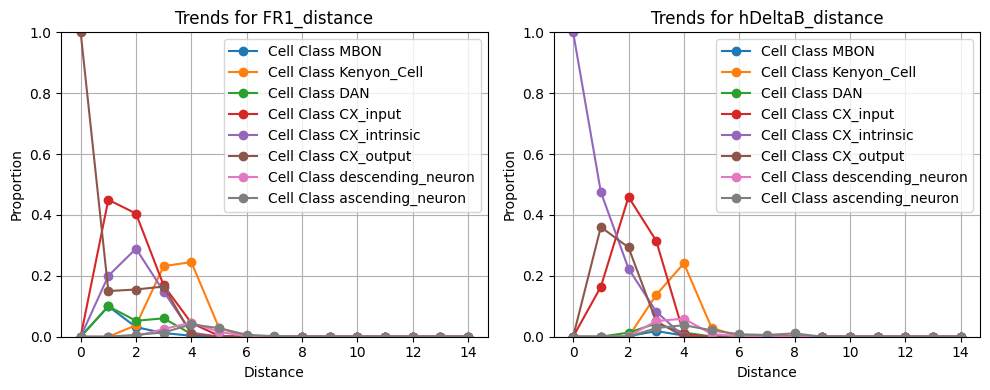

In [20]:
target_classes = ['MBON','Kenyon_Cell','DAN','CX_input','CX_intrinsic','CX_output','descending_neuron','ascending_neuron']
nonMBON_results = {k: v for k, v in result_all_distances.items() if 'MBON' not in k}
plot_all_cell_class_trends(nonMBON_results, target_classes, normalize=True)

/tmp/ipykernel_27873/1922922225.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, len(time_steps))
/tmp/ipykernel_27873/1922922225.py:71: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Time Step")


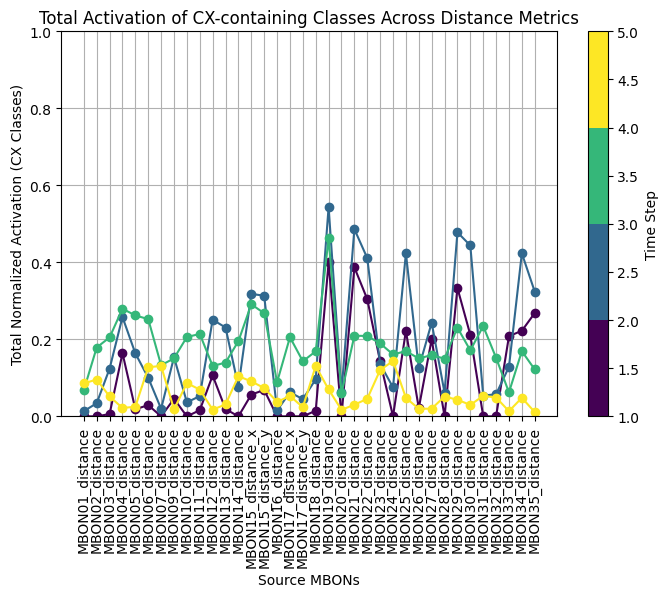

In [35]:
# Example usage
#target_class = 'CX_input'  # Cell class to analyze
plot_activation_across_distances(MBON_results, start=1, end=5)


{'LHLN', 'ME.LO', 'TH2_motor_neuron', 'ltm_motor_neuron', 'ME.LOP', 'wing_motor_neuron', 'i1_motor_neuron', 'LO>ME', 'enteric_gustatory', 'hDVM_motor_neuron', 'TBD', 'ALPN', 'Ta_depressor_motor_neuron', 'ps1_motor_neuron', 'DVM_1a-c_motor_neuron', 'ascending_neuron', 'abdomen_A1_motor_neuron', 'LO>LOP', 'pars_lateralis', 'TH1_motor_neuron', 'TPN', 'Tr_flexor_motor_neuron', 'LHCENT', 'AD_motor_neuron', 'visual', 'haltere_motor_neuron', 'DAN', 'multi_endocrine', 'abdomen_A2_endocrine', 'Tergotr._motor_neuron', 'hi2_motor_neuron', 'LOP>LO', 'ALLN', 'proprioceptive_sensory_ascending', 'TuBu', 'ME>LOP', 'endocrine_ascending', 'neck_motor_neuron', 'Acc._ti_flexor_motor_neuron', 'proprioceptive_sensory_neuron', 'LOP>ME', 'vnc_intrinsic_neuron', 'Ti_extensor_motor_neuron', 'NA_endocrine', 'hg1_motor_neuron', 'ME>LO', 'Pleural_remotor/abductor_motor_neuron', 'DVM_2a,_b_motor_neuron', 'DLM_c-f_motor_neuron', 'hiii2_motor_neuron', 'iii3_motor_neuron', 'NA_motor_neuron', 'tp2_motor_neuron', 'Stern

/tmp/ipykernel_24874/525498391.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, len(time_steps))
/tmp/ipykernel_24874/525498391.py:71: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Time Step")


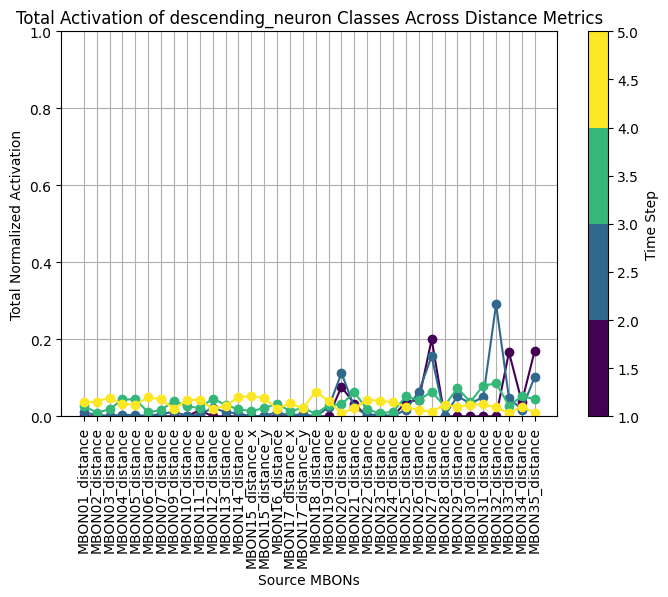

In [24]:
# Example usage
#target_class = 'CX_input'  # Cell class to analyze
plot_activation_across_distances(MBON_results, start=1, end=5,target_str='descending_neuron')


{'LHLN', 'ME.LO', 'TH2_motor_neuron', 'ltm_motor_neuron', 'ME.LOP', 'wing_motor_neuron', 'i1_motor_neuron', 'LO>ME', 'enteric_gustatory', 'hDVM_motor_neuron', 'TBD', 'ALPN', 'Ta_depressor_motor_neuron', 'ps1_motor_neuron', 'DVM_1a-c_motor_neuron', 'ascending_neuron', 'abdomen_A1_motor_neuron', 'LO>LOP', 'pars_lateralis', 'TH1_motor_neuron', 'TPN', 'Tr_flexor_motor_neuron', 'LHCENT', 'AD_motor_neuron', 'visual', 'haltere_motor_neuron', 'DAN', 'multi_endocrine', 'abdomen_A2_endocrine', 'Tergotr._motor_neuron', 'hi2_motor_neuron', 'LOP>LO', 'ALLN', 'proprioceptive_sensory_ascending', 'TuBu', 'ME>LOP', 'endocrine_ascending', 'neck_motor_neuron', 'Acc._ti_flexor_motor_neuron', 'proprioceptive_sensory_neuron', 'LOP>ME', 'vnc_intrinsic_neuron', 'Ti_extensor_motor_neuron', 'NA_endocrine', 'hg1_motor_neuron', 'ME>LO', 'Pleural_remotor/abductor_motor_neuron', 'DVM_2a,_b_motor_neuron', 'DLM_c-f_motor_neuron', 'hiii2_motor_neuron', 'iii3_motor_neuron', 'NA_motor_neuron', 'tp2_motor_neuron', 'Stern

/tmp/ipykernel_24874/525498391.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, len(time_steps))
/tmp/ipykernel_24874/525498391.py:71: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Time Step")


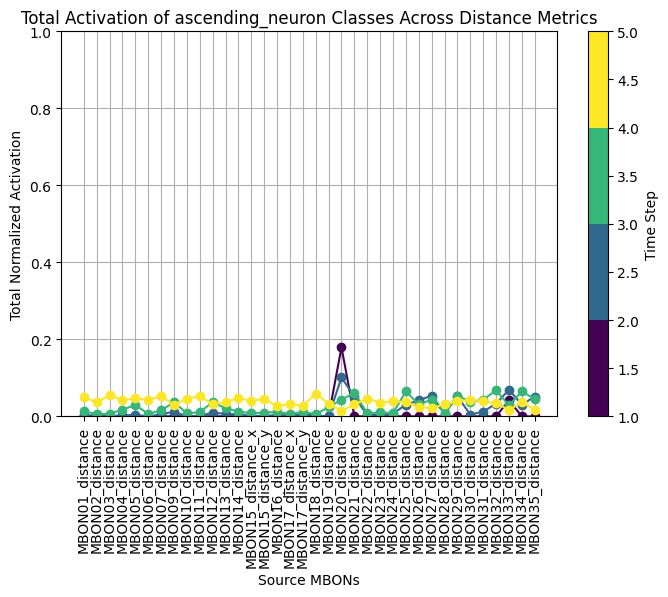

In [25]:
# Example usage
#target_class = 'CX_input'  # Cell class to analyze
plot_activation_across_distances(MBON_results, start=1, end=5,target_str='ascending_neuron')


In [39]:
distance_columns = ["MBON20_distance"]
MBON20_finegrained = group_cell_class_by_all_distances_2(merged_df, distance_columns, cell_class_col="cell_type", criteria_col="cell_class", target_value="ascending_neuron")

In [47]:
MBON20_finegrained['MBON20_distance'][1.0]

{'AN_multi_70': 2,
 'AN_SLP_AVLP_1': 2,
 'AN_multi_118': 1,
 'AN_multi_76': 1,
 'AN_SLP_LH_1': 1}

### Seed 10 analysis

In [11]:
merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/seed_10')

In [ ]:

distance_columns = list(merged_df.columns[36:])
result_all_distances = group_cell_class_by_all_distances(merged_df, distance_columns)

#print(result_all_distances)

In [59]:
merged_df.columns

Index(['id', 'fafb_id', 'manc_id', 'banc_id', 'dataset', 'region', 'modality',
       'seed', 'hemilineage', 'nerve', 'origin', 'target', 'serial_motif',
       'neuromere', 'morphology_group', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'sez_class', 'top_nt', 'top_nt_p',
       'known_nt', 'known_nt_source', 'soma_dcv_count', 'soma_dcv_density',
       'cell_dcv_count', 'cell_dcv_density', 'soma_volume', 'cable_length',
       'input_connections', 'input_degree', 'output_connections',
       'output_degree', 'side', 'antennal_distance', 'gustatory_distance',
       'proprioceptive_distance', 'tactile_distance'],
      dtype='object')

In [55]:
result_all_distances['gustatory_distance']

{1.0: {'vnc_intrinsic_neuron': 560,
  'ascending_neuron': 165,
  'tactile_sensory_neuron': 71,
  'unknown_sensory_neuron': 64,
  'chemosensory_sensory_neuron': 21,
  'descending_neuron': 21,
  'Kenyon_Cell': 16,
  'gustatory': 15,
  'ME>LO': 10,
  'ME': 10,
  'sensory_ascending': 9,
  'mAL': 3,
  'enteric_gustatory': 3,
  'chemosensory_sensory_ascending': 3,
  'ME>LO.LOP': 2,
  'TBD': 1,
  'Interneuron_TBD': 1,
  'unknown_sensory_ascending': 1},
 2.0: {'vnc_intrinsic_neuron': 6301,
  'tactile_sensory_neuron': 1518,
  'ascending_neuron': 828,
  'unknown_sensory_neuron': 582,
  'mechanosensory': 430,
  'descending_neuron': 274,
  'proprioceptive_sensory_neuron': 244,
  'Kenyon_Cell': 175,
  'gustatory': 125,
  'ME': 124,
  'ME>LO': 110,
  'sensory_ascending': 75,
  'chemosensory_sensory_neuron': 63,
  'LHON': 55,
  'abdomen_motor_neuron': 46,
  'mAL': 40,
  'ME>LOP': 37,
  'ME>LO.LOP': 33,
  'Acc._ti_flexor_motor_neuron': 20,
  'chemosensory_sensory_ascending': 19,
  'NA_endocrine': 16,


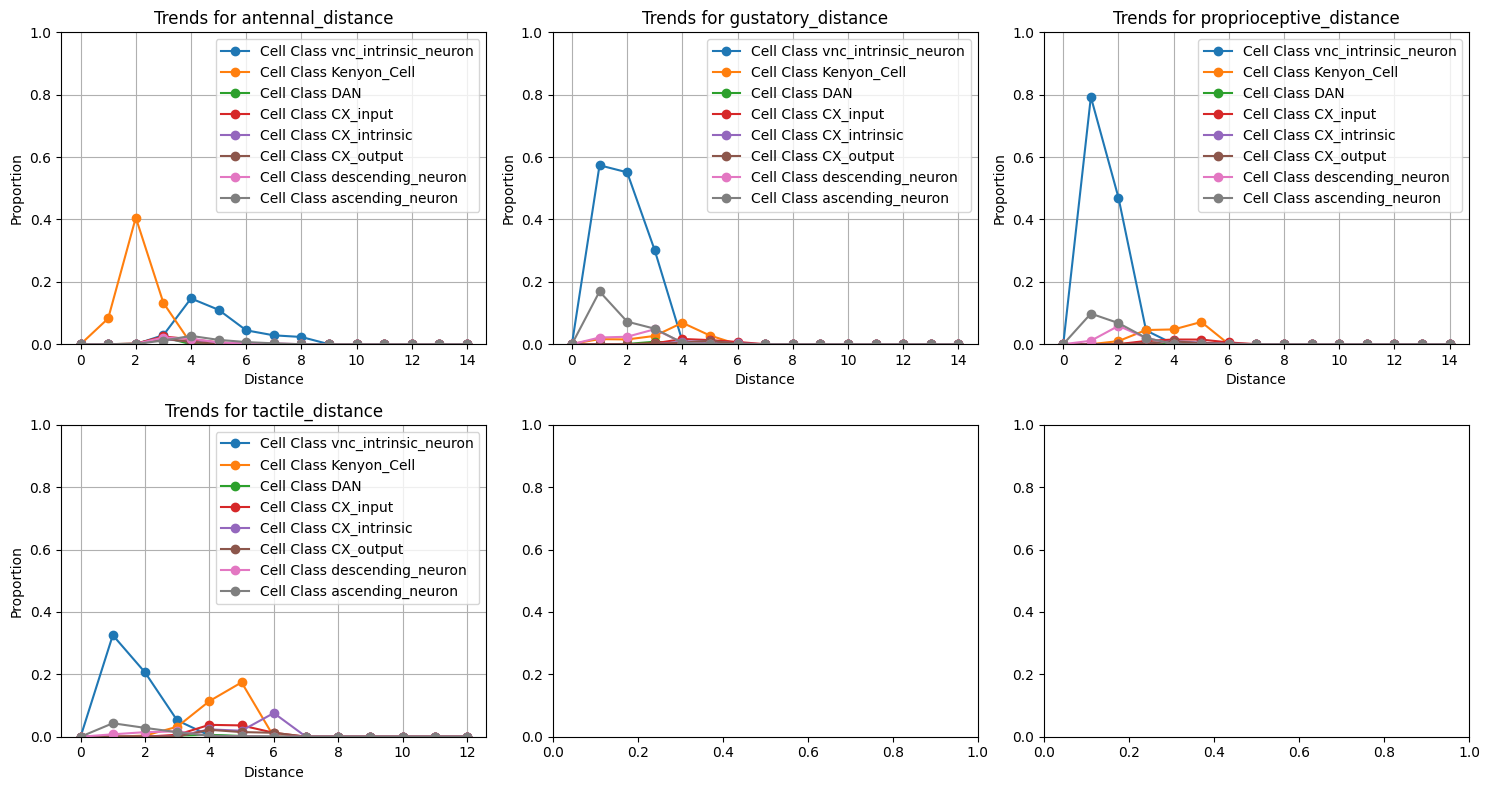

In [62]:
# Example usage
target_classes = ['vnc_intrinsic_neuron','Kenyon_Cell','DAN','CX_input','CX_intrinsic','CX_output','descending_neuron','ascending_neuron']
plot_all_cell_class_trends(result_all_distances, target_classes, normalize=True)

### DNg26

In [7]:
merged_df = merge_distance_dfs_banc(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/banc/DNg26')


In [42]:
tp2 = ['720575941476080948',
'720575941515349091']
DVM = ['720575941351637808',
'720575941590220684',
'720575941542328837',
'720575941484060422',
'720575941566929146',
'720575941560383347',
'720575941573368719',
'720575941597489344',
'720575941472734048',
'720575941572052381',
'720575941624985226',
'720575941530190027',
'720575941565105206',
'720575941603635190']
DLM =['720575941688219544',
'720575941514940153',
'720575941512954979',
'720575941533190337',
'720575941583644382',
'720575941479034563',
'720575941534583786',
'720575941545410921']
DNES2 =['720575941450146638',
'720575941551900159',
'720575941490203081']
DNES3 = ['720575941598389916',
'720575941451302825',
'720575941491151310']
CAPA = ['720575941429857239',
'720575941563686400']
Hugin = ['720575941538026109',
'720575941562301440',
'720575941577649909',
'720575941473952810']
PI = ['720575941526582093',
'720575941405981487',
'720575941552141191',
'720575941547129224',
'720575941617603029',
'720575941470714891',
'720575941548341053',
'720575941479865679',
'720575941402302320',
'720575941592128296',
'720575941458970067',
'720575941558193902',
'720575941435267872',
'720575941501345163',
'720575941541933341',
'720575941434301472',
'720575941479238563',
'720575941546985249',
'720575941538594802',
'720575941654072537',
'720575941449835342',
'720575941593259559',
'720575941572671227',
'720575941575047016',
'720575941535798755',
'720575941390588420',
'720575941448853173',
'720575941439389247',
'720575941585964766',
'720575941585502174',
'720575941553518983',
'720575941578171729',
'720575941440450239',
'720575941589027127',
'720575941428551817',
'720575941459243972',
'720575941464426582',
'720575941629686054']
IN19B090 = ['720575941553517796']
IN07B083 = ['720575941595969984']
DNg02_a = ['720575941595969984']
IN19B043 = ['720575941476965937','720575941564147346','720575941516099500']
DNg03 = ['720575941661415224']
DNg02a = ['720575941632002720']
IN19B067= ['720575941554049307','720575941594160421']
ANXXX202 = ['720575941651755797']
INXXX386 = ['720575941447863572']
AN06A030 = ['720575941546884641','720575941565124918']
ANXXX169 = ['720575941541839389']
result = get_pre_neuron_cell_types_banc(merged_df, edgelist_df, PI)
print(result)

{'DNg26_distance': {3: [('720575941541839389', 8)], 4: [('720575941579064565', 24), ('720575941579064565', 13), ('720575941610852938', 13), ('720575941461093316', 12), ('720575941590781324', 12), ('720575941526322788', 12), ('720575941569928436', 11), ('720575941525054233', 10), ('720575941564421015', 10), ('720575941537583331', 10), ('720575941461093316', 10), ('720575941579064565', 9), ('720575941564421015', 9), ('720575941579064565', 8), ('720575941430452750', 8), ('720575941461093316', 8), ('720575941569928436', 7), ('720575941651755797', 7), ('720575941579064565', 7), ('720575941461093316', 6), ('720575941461093316', 5), ('720575941414034204', 5), ('720575941590781324', 5), ('720575941416119068', 5), ('720575941441164991', 5), ('720575941525054233', 5), ('720575941579064565', 5), ('720575941430452750', 5), ('720575941528493700', 4), ('720575941461093316', 4), ('720575941590781324', 4), ('720575941441164991', 4), ('720575941537583331', 4), ('720575941537583331', 3), ('7205759414161

- DNg26 -> auto:IN11B018 -> DNg02_a -> tp2 MN
- DNg26 -> DNg06 -> IN19B090 -> tp2 MN
- DNg26 -> auto:IN11B018 -> IN07B083 -> tp2 MN

- DNg26 -> DNg03 -> IN19B043 -> DVM
- DNg26 -> DNg02a -> IN19B043 -> DVM

- DNg26 -> DNg03 -> IN19B067 -> DLM
- DNg26 -> DNg02a -> IN19B067 -> DLM

- DNg26 -> auto:INXXX363 -> INXXX386 -> ANXXX202 -> CAPA

- DNg26 -> IN07B090 -> AN06A030 -> Hugin

- DNg26 -> auto:INXXX363 -> ANXXX169 -> PI

In [43]:
result['DNg26_distance'][4]

[('720575941579064565', 24),
 ('720575941579064565', 13),
 ('720575941610852938', 13),
 ('720575941461093316', 12),
 ('720575941590781324', 12),
 ('720575941526322788', 12),
 ('720575941569928436', 11),
 ('720575941525054233', 10),
 ('720575941564421015', 10),
 ('720575941537583331', 10),
 ('720575941461093316', 10),
 ('720575941579064565', 9),
 ('720575941564421015', 9),
 ('720575941579064565', 8),
 ('720575941430452750', 8),
 ('720575941461093316', 8),
 ('720575941569928436', 7),
 ('720575941651755797', 7),
 ('720575941579064565', 7),
 ('720575941461093316', 6),
 ('720575941461093316', 5),
 ('720575941414034204', 5),
 ('720575941590781324', 5),
 ('720575941416119068', 5),
 ('720575941441164991', 5),
 ('720575941525054233', 5),
 ('720575941579064565', 5),
 ('720575941430452750', 5),
 ('720575941528493700', 4),
 ('720575941461093316', 4),
 ('720575941590781324', 4),
 ('720575941441164991', 4),
 ('720575941537583331', 4),
 ('720575941537583331', 3),
 ('720575941416119068', 3),
 ('720575

### Bitter

In [16]:
#merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/proprioception/cascade_2')
merged_df = merge_distance_dfs_banc(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/banc/bitter')

In [5]:
CB0135 = ['720575941564701703', '720575941590825100']
AN_GNG_136 = ['720575941510457872']
SNxx21 = ['720575941554774756',
'720575941533572530',
'720575941487700533',
'720575941430281464',
'720575941438421459',
'720575941532582787',
'720575941639356533',
'720575941516772499',
'720575941476542260',
'720575941528057220',
'720575941662579068',
'720575941518678894',
'720575941523078647']
SAchxx = ['720575941543379644']
AN05B076 = ['720575941429552815','720575941606579309']
PPL1012= ['720575941480571555',
'720575941476842014',
'720575941537560547',
'720575941450471246']
ANXXX433 = ['720575941434968974', '720575941560343155', '720575941525501517', '720575941534422360', '720575941592092968', '720575941490106830', '720575941520538803', '720575941513153745', '720575941439139535']
AN09B042 = ['720575941531283403']
AN05B004 = ['720575941458813680',
'720575941508517761']
mysterious_labellum = ['720575941642462565']
DNpe007 = ['720575941471958592']
LB1b = ['720575941505592901',
'720575941560643175',
'720575941610553318',
'720575941612070876',
'720575941679830717',
'720575941611051750',
'720575941632632992',
'720575941392695958',
'720575941638604149',
'720575941469733184']
#result = get_pre_neuron_cell_types_banc(merged_df, edgelist_df,PPL101)

In [25]:
test = edgelist_df[(edgelist_df.post.isin(CB0135)) & (edgelist_df.pre.isin(mysterious_labellum))]
test

,pre,post,count,norm,post_count,pre_count
534814,720575941642462565,720575941590825100,10,0.011038,906,1025


In [21]:
result = get_pre_neuron_cell_types_banc(merged_df, edgelist_df,mysterious_labellum)
print(result)

{'abdomen_distance': {3: [('720575941529731768', 26), ('720575941426831444', 16), ('720575941528930232', 15), ('720575941445475348', 12), ('720575941471925568', 7), ('720575941515054659', 7), ('720575941447163317', 6), ('720575941643058533', 6), ('720575941512261443', 5), ('720575941527849638', 5), ('720575941411188395', 4), ('720575941536037362', 4), ('720575941568818938', 3), ('720575941613453532', 3), ('720575941624166908', 3), ('720575941631060972', 3), ('720575941662502268', 3), ('720575941679106749', 3), ('720575941352918576', 2), ('720575941473812576', 2), ('720575941474229297', 2), ('720575941486460813', 2), ('720575941493278384', 2), ('720575941501757323', 2), ('720575941513651532', 2), ('720575941533906008', 2), ('720575941535538202', 2), ('720575941573383581', 2), ('720575941595771548', 2), ('720575941392665750', 1), ('720575941414253969', 1), ('720575941438395967', 1), ('720575941443958954', 1), ('720575941449740213', 1), ('720575941461092036', 1), ('720575941474456350', 1)

In [25]:
result.keys()

dict_keys(['abdomen_distance', 'labellum_distance'])

In [22]:
result['labellum_distance'][1]

[('720575941392695958', 9),
 ('720575941638604149', 7),
 ('720575941545598313', 6),
 ('720575941560643175', 6),
 ('720575941498150985', 3),
 ('720575941505592901', 3),
 ('720575941568818938', 3),
 ('720575941610553318', 2),
 ('720575941410224811', 1),
 ('720575941474115626', 1),
 ('720575941476174385', 1),
 ('720575941485557058', 1),
 ('720575941612070876', 1),
 ('720575941654300121', 1),
 ('720575941661903160', 1),
 ('720575941662198652', 1)]

In [35]:
SNxx20 = ['720575941568547186',
'720575941561307794',
'720575941503527986',
'720575941558433295',
'720575941556893476',
'720575941588546871',
'720575941517769644',
'720575941566646574',
'720575941449990237',
'720575941680553149',
'720575941437561941',
'720575941501993355',
'720575941522128119',
'720575941515659523',
'720575941531649253',
'720575941404057712',
'720575941507457570',
'720575941573706504',
'720575941642256248',
'720575941492456574',
'720575941652784913',
'720575941564002407']


In [36]:
test = edgelist_df[(edgelist_df.post.isin(AN_GNG_136)) & (edgelist_df.pre.isin(SNxx20))]

In [39]:
sum(test.count())
### Nociception

36

### Nociception

In [ ]:
#merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/nociception/cascade')
merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/proprioception/cascade_2')
#merged_df = merge_distance_dfs_banc(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/banc/nociception')

KeyError: 'id'

In [7]:
result = get_pre_neuron_cell_types_banc(merged_df, edgelist_df, DNpe007)
print(result)

{'abdomen_distance': {2: [('SA_VTV_6', 7), ('AN_GNG_71', 4), ('AN_GNG_70', 4), ('AN_GNG_SAD_20', 2), ('AN_GNG_195', 2), ('AN_multi_117', 1)], 3: [('CB0413', 30), ('CB0413', 20), ('AN_FLA_GNG_2', 16), ('CB0153', 15), ('DNpe007', 15), ('CB3485', 13), ('CB0512', 11), ('SA_VTV_6', 10), ('CB0959', 9), ('DNg22', 8), ('CB0602', 7), ('CB0684', 6), ('AN_GNG_68', 6), ('SMP056', 5), ('AN_AVLP_26', 5), ('unknown', 5), ('DNd03', 4), ('DNd04', 4), ('CB3687', 4), ('AN_GNG_71', 4), ('CB3500', 4), ('CB0959', 3), ('CB0602', 3), ('AN_multi_82', 3), ('DNp65', 3), ('CB0586', 3), ('CB1718', 3), ('', 3), ('SA_VTV_6', 2), ('CB3884', 2), ('AN_AVLP_GNG_13', 2), ('CB0191', 2), ('AN_multi_98', 2), ('CB2388', 2), ('CB0959', 2), ('mAL', 2), ('CB0323', 2), ('DNd04', 2), ('labial_nerve_sensory_descending', 2), ('AN_GNG_SAD_5', 2), ('AN_GNG_PRW_1', 1), ('CB2291', 1), ('AN_multi_82', 1), ('', 1), ('AN_multi_75', 1), ('CB0310', 1), ('AN_multi_90', 1), ('CB0458', 1), ('DNp25', 1), ('CB0113', 1), ('DNpe007', 1), ('SA_VTV_

In [89]:
result['abdomen_distance'][2]

[('AN_GNG_118', 34),
 ('AN_GNG_70', 28),
 ('SA_VTV_6', 17),
 ('DNxl071', 17),
 ('DNxl071', 13),
 ('SA_VTV_3', 9),
 ('AN_3_None', 8),
 ('AN_GNG_111', 5),
 ('SNxx22', 4),
 ('AN_GNG_71', 3),
 ('AN_GNG_71', 2),
 ('AN_3_None', 2),
 ('AN_GNG_70', 2),
 ('IN23B055', 2),
 ('IN23B055', 2),
 ('SNxx29', 2),
 ('AN_multi_121', 2),
 ('INXXX224', 2),
 ('AN_SAD_FLA_1', 2),
 ('INXXX084', 2),
 ('INXXX084', 2),
 ('SA_VTV_6', 1),
 ('INXXX332', 1),
 ('AN_GNG_SAD_6', 1),
 ('SNxx25', 1),
 ('SNxx21', 1),
 ('INXXX400', 1),
 ('IN01A061', 1),
 ('IN01A059', 1),
 ('IN23B058', 1),
 ('IN03A052', 1),
 ('IN14A020', 1),
 ('INXXX019', 1),
 ('IN01A045', 1),
 ('IN03A055', 1),
 ('DNg80', 1),
 ('AN_GNG_SAD_5', 1),
 ('AN_AVLP_17', 1),
 ('AN_GNG_195', 1),
 ('AN_multi_117', 1),
 ('DNg80', 1),
 ('IN14A020', 1),
 ('IN23B055', 1),
 ('', 1),
 ('DNxn180', 1),
 ('SNxx25', 1),
 ('IN23B058', 1),
 ('INXXX019', 1),
 ('DNxl071', 1),
 ('INXXX245', 1),
 ('IN23B058', 1),
 ('AN_GNG_195', 1),
 ('IN01A061', 1),
 ('ANXXX196', 1),
 ('IN23B032', 1

In [90]:
result['front_distance'][1]

KeyError: 1

In [73]:
result['hind_distance'][1]

KeyError: 1

In [74]:
result['middle_distance'][1]

KeyError: 1

In [92]:
result['wing_distance'][1]

[('SNxx25', 28), ('SNxx25', 27), ('SNxx25', 1), ('SNxx25', 1), ('SNxx25', 1)]

In [93]:
result['haltere_distance'][2]

[('DNxl071', 17), ('AN_SAD_FLA_1', 2), ('DNxl071', 1)]

In [19]:

distance_columns = list(merged_df.columns[36:])
result_all_distances = group_cell_class_by_all_distances(merged_df, distance_columns, cell_class_col="cell_type")

#print(result_all_distances)

In [20]:
result_all_distances['nociception_distance']

{3.0: {'BM_InOm': 756,
  'SNta29': 165,
  'AN_4_None': 147,
  'SNxxxx': 134,
  'SNta37': 120,
  'SNta38': 108,
  'JO-B': 101,
  'SNppxx': 99,
  'SNta20': 98,
  'SNch05': 95,
  'SNta09': 88,
  'SNta28': 76,
  'JO-A': 71,
  'SNta30': 68,
  'LB3': 67,
  'SNxx33': 67,
  'SNch03': 61,
  'BM_Taste': 61,
  'SNpp50': 60,
  'SNta21': 60,
  'SNta44': 53,
  'SNch09': 51,
  'SNta25': 51,
  'SNta14': 48,
  'SNta02': 48,
  'SNta42': 48,
  'JO-F': 47,
  'mAL': 46,
  'SNta31': 44,
  'SNpp60': 41,
  'LC9': 40,
  'SNch07': 37,
  'SNta40': 37,
  'SNta23': 37,
  'SNta27': 37,
  'KCg-m': 35,
  'SNta26': 34,
  'SNch12': 33,
  'SA_DMT_DMetaN_12': 33,
  'SNch11': 33,
  'SNpp39': 32,
  'SNta43': 31,
  'SNta41': 31,
  'PI': 30,
  'pharyngeal_nerve_sensory_group2': 30,
  'PS005': 29,
  'CL121,CL122': 28,
  'BM_Ant': 28,
  'TPMN': 27,
  'SNpp02': 27,
  'AN_GNG_165': 26,
  'Tr flexor MN': 26,
  'SNpp45': 26,
  'SNta32': 26,
  'SA_DMT_DMetaN': 25,
  'SNta45': 25,
  'SNxx07': 25,
  'BM_MaPa': 24,
  'BM_Vib': 24,
  '

In [21]:
DAN_df = meta_df[meta_df['cell_class'] == 'DAN']
DAN_df

,id,fafb_id,manc_id,banc_id,dataset,region,modality,seed,hemilineage,nerve,...,soma_dcv_density,cell_dcv_count,cell_dcv_density,soma_volume,cable_length,input_connections,input_degree,output_connections,output_degree,side
20625,720575940604479590,720575940604479590,None,None,FAFB,midbrain,None,None,CREa2_medial,None,...,0.382,1285,0.9568,12827215,1343.0,629.0,403.0,280.0,187.0,left
20830,720575940604728800,720575940604728800,None,None,FAFB,midbrain,None,None,CREa2_medial,None,...,0.5095,549,0.5055,12757682,1086.0,252.0,161.0,112.0,82.0,left
20958,720575940604861356,720575940604861356,None,None,FAFB,midbrain,None,None,CREa1_dorsal,None,...,0.5751,587,0.4776,12171890,1229.0,205.0,114.0,64.0,40.0,right
21247,720575940605113376,720575940605113376,None,None,FAFB,midbrain,None,None,CREa1_dorsal,None,...,0.7298,1392,0.9219,15073475,1510.0,348.0,223.0,148.0,119.0,right
21364,720575940605221065,720575940605221065,None,None,FAFB,midbrain,None,None,CREa2_medial,None,...,1.049,724,0.4866,3337360,1488.0,367.0,243.0,94.0,75.0,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154268,720575940653360289,720575940653360289,None,None,FAFB,midbrain,None,None,CREa2_medial,None,...,0.889,1965,1.616,15748710,1216.0,264.0,165.0,245.0,112.0,right
154483,720575940654661281,720575940654661281,None,None,FAFB,midbrain,None,None,CREa2_medial,None,...,0.582,1540,1.091,12198265,1412.0,503.0,307.0,121.0,91.0,right
154903,720575940658674049,720575940658674049,None,None,FAFB,midbrain,None,None,CREa1_dorsal,None,...,0.5468,1004,0.7572,12252501,1326.0,240.0,138.0,165.0,117.0,right
155093,720575940660053121,720575940660053121,None,None,FAFB,midbrain,None,None,CREa2_medial,None,...,0.2984,2371,0.8414,11394562,2818.0,2245.0,451.0,728.0,328.0,left


In [22]:
DAN_df.cell_type.unique()

array(['PAM08', 'PAM13', 'PAM12', 'PAM01', 'PAM11', 'PAM05', 'PAM06',
       'PPL106', 'PAM04', 'PAM07', 'PAM10', 'PAM09', 'PAM14', 'PAM02',
       'PPL204', 'PPL108', 'PPL107', 'PPL101', 'PPL203', 'PPL202',
       'PAM03', 'PPL201', 'PPL105', 'CB2730', 'PPL102', 'PPL104',
       'PPL103', 'PAM15'], dtype=object)

In [28]:
body_part_results = {k: v for k, v in result_all_distances.items() if 'nociception' not in k}

/tmp/ipykernel_17802/1433883778.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap, len(target_classes))


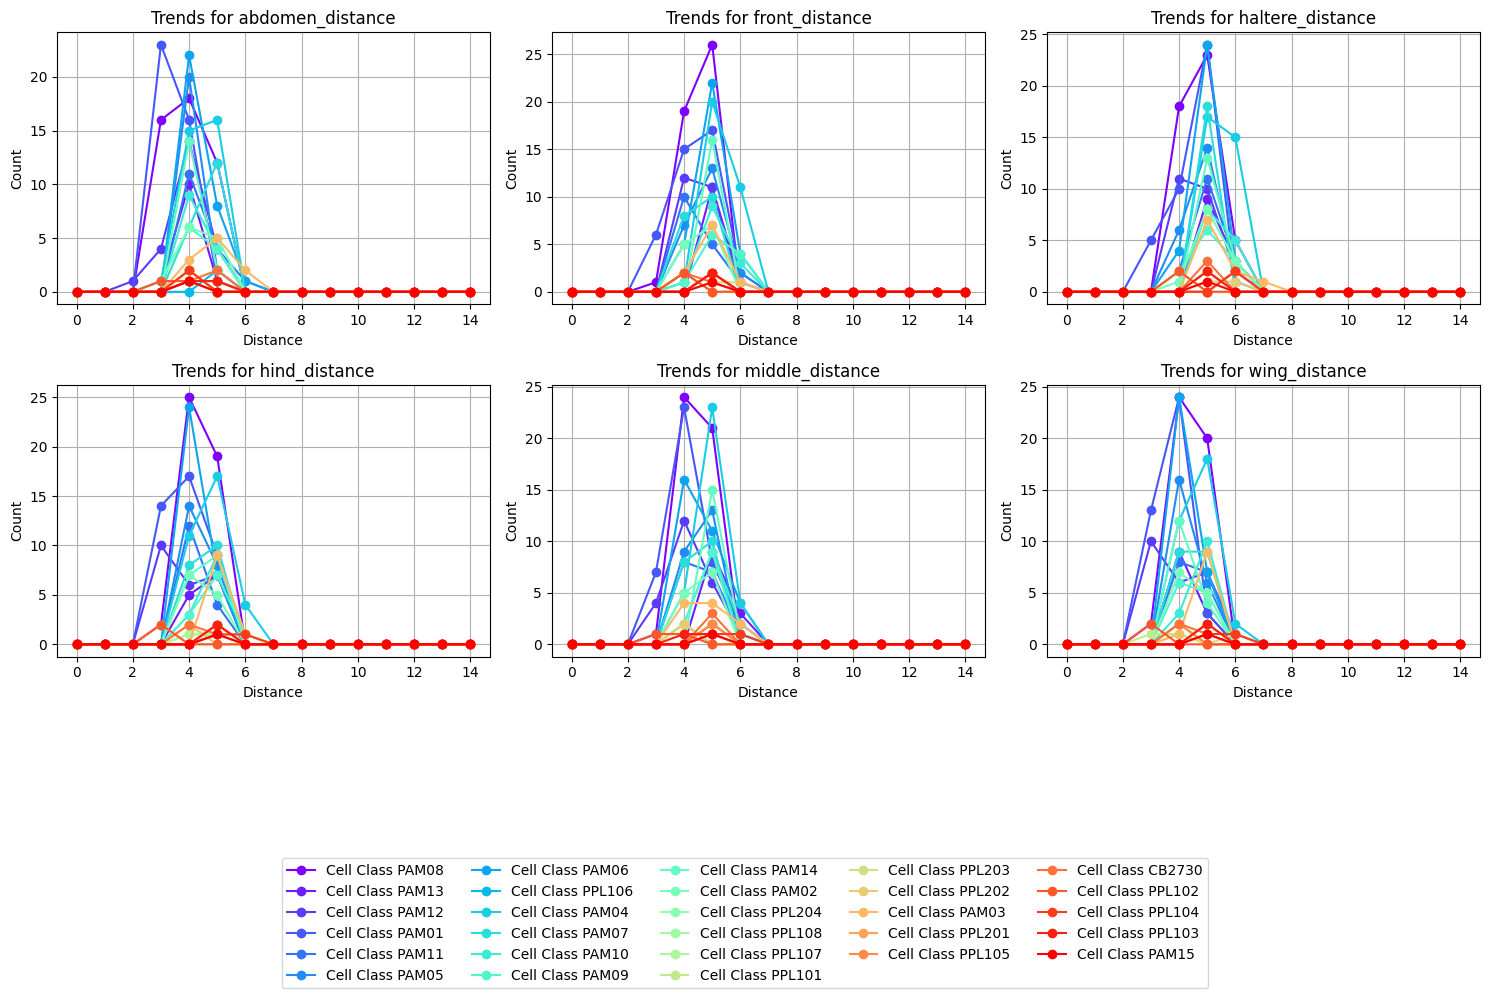

In [29]:
# Example usage
target_classes = list(DAN_df.cell_type.unique())
DAN_trend = plot_all_cell_class_trends(body_part_results, target_classes, normalize=False,colormap="rainbow")

In [33]:
DAN_trend['abdomen_distance']

{'PAM08': {'distances': [3.0, 4.0, 5.0], 'counts': [16.0, 18.0, 12.0]},
 'PAM13': {'distances': [3.0, 4.0, 5.0], 'counts': [1.0, 10.0, 1.0]},
 'PAM12': {'distances': [2.0, 3.0, 4.0, 5.0], 'counts': [1.0, 4.0, 14.0, 4.0]},
 'PAM01': {'distances': [3.0, 4.0, 5.0], 'counts': [23.0, 16.0, 1.0]},
 'PAM11': {'distances': [4.0, 5.0, 6.0], 'counts': [11.0, 4.0, 1.0]},
 'PAM05': {'distances': [4.0, 5.0], 'counts': [20.0, 2.0]},
 'PAM06': {'distances': [4.0, 5.0, 6.0], 'counts': [22.0, 8.0, 1.0]},
 'PPL106': {'distances': [5.0], 'counts': [2.0]},
 'PAM04': {'distances': [3.0, 4.0, 5.0], 'counts': [1.0, 15.0, 16.0]},
 'PAM07': {'distances': [4.0, 5.0], 'counts': [6.0, 12.0]},
 'PAM10': {'distances': [4.0, 5.0], 'counts': [9.0, 4.0]},
 'PAM09': {'distances': [3.0, 4.0, 5.0], 'counts': [1.0, 6.0, 4.0]},
 'PAM14': {'distances': [4.0, 5.0], 'counts': [14.0, 2.0]},
 'PAM02': {'distances': [3.0, 4.0, 5.0], 'counts': [1.0, 6.0, 5.0]},
 'PPL204': {'distances': [4.0, 5.0], 'counts': [1.0, 1.0]},
 'PPL108'

### Proprioception

In [5]:
#merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/proprioception/cascade_2')
merged_df = merge_distance_dfs_banc(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/banc/proprioception')

In [6]:
merged_df

,root_id,supervoxel_id,position,side,root_region,region,hemilineage,nerve,neuromere,super_class,...,seed_05,seed_06,seed_07,seed_08,seed_09,seed_10,seed_11,haltere_distance,notum_distance,wing_distance
0,720575941503412203,75365681398737722,"97680, 23392, 1916",right,ITO_midbrain_AL_R,midbrain,None,right antennal nerve,None,sensory,...,None,None,None,None,None,None,None,2.0,5.0,2.0
1,720575941671353767,76142074248072351,"119782, 92500, 2627",right,ITO_midbrain_PLP_R,neck_connective,None,None,None,descending,...,None,None,None,None,None,None,None,3.0,5.0,3.0
2,720575941561088045,76212442992558863,"122623, 92500, 2732",right,None,neck_connective,None,None,None,descending,...,None,None,None,None,None,None,None,3.0,4.0,3.0
3,720575941662395704,76212442992686915,"121893, 92500, 2780",left,ITO_midbrain_AVLP_L,neck_connective,None,None,None,descending,...,None,None,None,None,None,None,None,2.0,4.0,2.0
4,720575941632903621,75930968015558765,"113836, 92500, 2776",left,ITO_midbrain_WED_L,neck_connective,None,None,None,descending,...,None,None,None,None,None,None,None,2.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118987,720575941598556608,78392362434938260,"184764,47976,3505",left,ITO_optic_LOP_L,optic,None,None,None,None,...,None,None,None,None,None,None,None,5.0,6.0,5.0
118988,720575941624067836,78462593404773677,"188090,43430,2271",left,ITO_optic_LOP_L,optic,None,None,None,None,...,None,None,None,None,None,None,None,5.0,6.0,5.0
118989,720575941690613211,79517780701335032,"217309,33310,1140",left,ITO_optic_ME_L,optic,None,None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
118990,720575941451841914,74169756949421701,"62080,34554,4318",right,ITO_optic_ME_R,optic,None,None,None,None,...,None,None,None,None,None,None,None,6.0,7.0,6.0


In [11]:
GLNO = ['720575941476402462',
'720575941518740440',
'720575941690298264',
'720575941438937663']
PS196b = ['720575941431019401','720575941590403326']
AN_IPS_LAL_1 = ['720575941538534130',
'720575941486586374',
'720575941490912460',
'720575941481149891',
'720575941525280166',
'720575941572427678']
IN_mys = ['720575941572851087']
SApp05 = ['720575941611005414',
'720575941512840953',
'720575941483888450',
'720575941662536316',
'720575941563568999',
'720575941471308896',
'720575941597150364',
'720575941590343976',
'720575941548843581',
'720575941590343976',
'720575941539005426',
'720575941604710334',
'720575941532088920',
'720575941525881188',
'720575941688267416',
'720575941574253563',
'720575941456093936',
'720575941611138918',
'720575941658075728',
'720575941595697285',
'720575941611138918',
'720575941473780832',
'720575941569027316',
'720575941458666195',
'720575941616978303',
'720575941451287879',
'720575941441958607',
'720575941461227987',
'720575941662429308',
'720575941548927521',
'720575941632670395',
'720575941612586137',
'720575941485651206',
'720575941481722819']
SApp08 = ['720575941492249776',
'720575941494185344',
'720575941516887918',
'720575941474474270',
'720575941438206431',
'720575941513411930',
'720575941414315409',
'720575941630308549',
'720575941447918414',
'720575941435418656',
'720575941532194282',
'720575941603710137',
'720575941550675079',
'720575941551911935',
'720575941557692531',
'720575941461178067',
'720575941631933893',
'720575941470090615',
'720575941459431494',
'720575941437152300',
'720575941470835264',
'720575941637903733',
'720575941557372708',
'720575941532500146',
'720575941497832777',
'720575941477345332',
'720575941537644003',
'720575941466319382',
'720575941438449708',
'720575941477345332',
'720575941471910976',
'720575941641037925',
'720575941534770954',
'720575941476481345',
'720575941611709715',
'720575941518642030',
'720575941458206879',
'720575941611709715']
SNpp20 = ['720575941543388421',
'720575941483643578',
'720575941689772251',
'720575941703025882',
'720575941435699744',
'720575941526720589',
'720575941702233818',
'720575941459926854',
'720575941479305952',
'720575941481133309',
'720575941593388145',
'720575941506032151',
'720575941555209956',
'720575941441792463',
'720575941471487499',
'720575941568852212',
'720575941656018968']
SApp03 =['720575941572840591',  
'720575941513214979',
'720575941504032933',
'720575941572979016',
'720575941571698184',
'720575941538259349',
'720575941533064323',
'720575941530894211',
'720575941680284605',
'720575941513672268',
'720575941633650107',
'720575941566772526',
'720575941625769068',
'720575941451087226',
'720575941573316603',
'720575941512934353',
'720575941553039643',
'720575941616556757',
'720575941596442501',
'720575941513672268',
'720575941513672268',
'720575941513672268',
'720575941513672268',
'720575941513672268',
'720575941513672268',
'720575941513672268',
'720575941513672268']
SApp02 = ['720575941538881778',
'720575941514537731',
'720575941562316039',
'720575941483870018',
'720575941631952837',
'720575941498290850',
'720575941525311654',
'720575941479326432',
'720575941392725252',
'720575941538930837',
'720575941535207651',
'720575941511199564',
'720575941485319234',
'720575941537193699',
'720575941447888916',
'720575941551013375',
'720575941661281592',
'720575941538930837',
'720575941610629852']

In [14]:
test = edgelist_df[(edgelist_df.post.isin(AN_IPS_LAL_1)) & (edgelist_df.pre.isin(SApp03))]
test

,pre,post,count,norm,post_count,pre_count
3075854,720575941513214979,720575941525280166,2,0.003643,549,143
3522773,720575941572979016,720575941525280166,2,0.003643,549,203
5694079,720575941513214979,720575941572427678,1,0.001689,592,143
6107708,720575941533064323,720575941525280166,1,0.001821,549,170
6107715,720575941533064323,720575941572427678,1,0.001689,592,170
6262693,720575941538259349,720575941490912460,1,0.001164,859,382


In [15]:
test['count'].sum()

8

In [61]:
result = get_pre_neuron_cell_types_banc(merged_df, edgelist_df,IN_mys)
print(result)

{'haltere_distance': {1: [('720575941569027316', 3), ('720575941616978303', 3), ('720575941441958607', 2), ('720575941461227987', 1), ('720575941543388421', 1), ('720575941611709715', 1)]}, 'notum_distance': {3: [('720575941526970552', 4), ('720575941413255569', 2), ('720575941432287703', 2), ('720575941475623274', 2)]}, 'wing_distance': {2: [('720575941496116352', 8), ('720575941626065772', 5), ('720575941549397247', 3), ('720575941450363770', 2), ('720575941470067063', 2), ('720575941475996465', 2), ('720575941492467070', 2), ('720575941579809013', 2), ('720575941626272650', 2), ('720575941632614587', 2), ('720575941633109664', 2), ('720575941350441008', 1), ('720575941452772167', 1), ('720575941461235088', 1), ('720575941471150455', 1), ('720575941476036894', 1), ('720575941490704073', 1), ('720575941491629287', 1), ('720575941504443074', 1), ('720575941515619939', 1), ('720575941519465582', 1), ('720575941549297919', 1), ('720575941559301491', 1), ('720575941590112040', 1), ('72057

In [10]:
result.keys()

dict_keys(['haltere_distance', 'notum_distance', 'wing_distance'])

In [15]:
meta_df.columns

Index(['root_id', 'supervoxel_id', 'position', 'side', 'root_region', 'region',
       'hemilineage', 'nerve', 'neuromere', 'super_class', 'cell_class',
       'cell_sub_class', 'top_nt', 'seed_00', 'seed_01', 'seed_02', 'seed_03',
       'seed_04', 'seed_05', 'seed_06', 'seed_07', 'seed_08', 'seed_09',
       'seed_10', 'seed_11'],
      dtype='object')

In [62]:
result['haltere_distance'][1]

[('720575941569027316', 3),
 ('720575941616978303', 3),
 ('720575941441958607', 2),
 ('720575941461227987', 1),
 ('720575941543388421', 1),
 ('720575941611709715', 1)]

In [24]:
result['middle_distance'][3]

[('PS198', 128),
 ('PS047b', 8),
 ('PS239', 1),
 ('CB0547', 2),
 ('CB0595', 6),
 ('CB0695', 3),
 ('PPM1201', 1),
 ('PS047a', 1),
 ('CB0619', 2),
 ('PS198', 79),
 ('mALD4', 58),
 ('PS047b', 5),
 ('CB0688', 2),
 ('PS261', 4),
 ('CB0619', 6),
 ('CB2697', 1),
 ('PS048a', 3),
 ('AN_IPS_GNG_7', 1),
 ('AN_IPS_WED_1', 1),
 ('CB1042', 1),
 ('AN_multi_58', 1),
 ('PS099a', 1),
 ('PS239', 1)]

In [25]:
result['wing_distance'][3]

[('OA-VUMa8', 1),
 ('mALD4', 59),
 ('PS048b', 3),
 ('CB2000', 1),
 ('CB0547', 2),
 ('PS261', 1),
 ('AN_multi_11', 6),
 ('AN_multi_47', 1),
 ('CB0040', 3),
 ('AN_multi_11', 4),
 ('mALD4', 58),
 ('SMP048', 2),
 ('LAL111,PS060', 1),
 ('AN_multi_11', 1),
 ('OA-VUMa8', 2)]

In [121]:
result['haltere_distance'][2]

[('AN_multi_11', 28),
 ('AN_multi_11', 28),
 ('AN_multi_11', 26),
 ('AN_multi_11', 21),
 ('AN_multi_11', 20),
 ('AN_multi_11', 17),
 ('AN_multi_11', 9),
 ('AN_multi_11', 7),
 ('AN_multi_12', 1)]

In [59]:
result = get_pre_neuron_cell_types(merged_df, edgelist_df, target_cell_type="ExR8")
print(result)

{'abdomen_distance': {}, 'front_distance': {4: [('CB1609', 2), ('CB1021', 1), ('CB0295', 1), ('ExR4', 34), ('PS291', 13), ('WED095', 1), ('PS047a', 3), ('CB1264', 1), ('PS099b', 2), ('AN_IPS_WED_1', 2), ('PS262', 6), ('AN_IPS_GNG_7', 2), ('CB0657', 1), ('CB.FB3,4A10', 1), ('PS048b', 5), ('CB3220', 1), ('PS292', 5), ('PS196b', 1), ('CB0149', 5), ('LAL184', 3), ('ExR2_1', 2), ('PS047b', 4), ('AN_IPS_LAL_1', 2), ('LAL165', 1), ('DNge071', 1), ('LAL168b', 1), ('PS198', 2), ('LAL122', 1), ('PS292', 1), ('PS239', 1), ('AN_IPS_GNG_7', 1), ('PS239', 1), ('PS291', 31), ('PS048b', 2), ('CB3220', 3), ('PS291', 14), ('PS292', 1), ('PS292', 12), ('WED038a', 1), ('VES056', 1), ('ExR4', 15), ('LAL176,LAL177', 1), ('CB0080', 2), ('PS099b', 1), ('CB0657', 3), ('CB1609', 1), ('CL131', 1), ('LAL203', 1), ('PS099a', 11), ('LAL082', 1), ('PS196b', 1), ('AN_multi_125', 1), ('LAL158', 1), ('LAL085', 2), ('CB1131', 2), ('LB7_11', 1), ('CB2497', 1), ('VCH', 1), ('CB2804', 1), ('CB1042', 1), ('CB1042', 1), ('CB

In [73]:
result['front_distance'][4]

[('CB1609', 2),
 ('CB1021', 1),
 ('CB0295', 1),
 ('ExR4', 34),
 ('PS291', 13),
 ('WED095', 1),
 ('PS047a', 3),
 ('CB1264', 1),
 ('PS099b', 2),
 ('AN_IPS_WED_1', 2),
 ('PS262', 6),
 ('AN_IPS_GNG_7', 2),
 ('CB0657', 1),
 ('CB.FB3,4A10', 1),
 ('PS048b', 5),
 ('CB3220', 1),
 ('PS292', 5),
 ('PS196b', 1),
 ('CB0149', 5),
 ('LAL184', 3),
 ('ExR2_1', 2),
 ('PS047b', 4),
 ('AN_IPS_LAL_1', 2),
 ('LAL165', 1),
 ('DNge071', 1),
 ('LAL168b', 1),
 ('PS198', 2),
 ('LAL122', 1),
 ('PS292', 1),
 ('PS239', 1),
 ('AN_IPS_GNG_7', 1),
 ('PS239', 1),
 ('PS291', 31),
 ('PS048b', 2),
 ('CB3220', 3),
 ('PS291', 14),
 ('PS292', 1),
 ('PS292', 12),
 ('WED038a', 1),
 ('VES056', 1),
 ('ExR4', 15),
 ('LAL176,LAL177', 1),
 ('CB0080', 2),
 ('PS099b', 1),
 ('CB0657', 3),
 ('CB1609', 1),
 ('CL131', 1),
 ('LAL203', 1),
 ('PS099a', 11),
 ('LAL082', 1),
 ('PS196b', 1),
 ('AN_multi_125', 1),
 ('LAL158', 1),
 ('LAL085', 2),
 ('CB1131', 2),
 ('LB7_11', 1),
 ('CB2497', 1),
 ('VCH', 1),
 ('CB2804', 1),
 ('CB1042', 1),
 ('CB10

In [66]:
result['middle_distance'][3]

[('AN_multi_58', 3),
 ('CB2697', 3),
 ('PS099a', 11),
 ('PS048a', 2),
 ('PS261', 1),
 ('CB1042', 1),
 ('PS047b', 3),
 ('PS099a', 1),
 ('LAL167b', 1)]

In [65]:
result['hind_distance'][3]

[('PS099a', 5),
 ('AN_IPS_GNG_7', 2),
 ('PS047b', 4),
 ('AN_IPS_LAL_1', 2),
 ('AN_IPS_GNG_7', 2),
 ('CB1229', 1),
 ('PS198', 4),
 ('LAL168b', 1),
 ('PS198', 2),
 ('AN_IPS_GNG_7', 1),
 ('AN_multi_58', 3),
 ('PS048a', 2),
 ('LAL168b', 1),
 ('PS047b', 3),
 ('PS099a', 1),
 ('LAL167b', 1),
 ('CB1834', 1)]

In [67]:
result['haltere_distance'][3]

[('PS099a', 5),
 ('CB1264', 1),
 ('PS099b', 2),
 ('AN_multi_14', 1),
 ('CB1229', 1),
 ('LAL168b', 1),
 ('WED038a', 1),
 ('CB0675', 1),
 ('PS099b', 1),
 ('CB1609', 1),
 ('CB2697', 3),
 ('PS099a', 11),
 ('CB2497', 1),
 ('CB2804', 1),
 ('CB1042', 1),
 ('CB1042', 1),
 ('CB1264', 1),
 ('CB1042', 1),
 ('PS099a', 1),
 ('DNge116', 1)]

In [71]:
result['wing_distance'][3]

[('CB1021', 1), ('PS261', 4), ('PS262', 6), ('PS048b', 5), ('AN_multi_14', 1)]

### Tactile

In [74]:
merged_df = merge_distance_dfs(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/tactile/cascade')

In [117]:
result = get_pre_neuron_cell_types(merged_df, edgelist_df, target_cell_type="ExR8")
print(result)

{'front_distance': {4: [('CB1609', 2), ('CB1021', 1), ('WED095', 1), ('PS047a', 3), ('PS099a', 5), ('CB1264', 1), ('AN_IPS_WED_1', 2), ('AN_IPS_GNG_7', 2), ('OA-AL2i4', 1), ('PS048b', 5), ('PS291', 9), ('CB0149', 5), ('LAL184', 3), ('PS047b', 4), ('AN_multi_14', 1), ('AN_IPS_GNG_7', 2), ('CB1229', 1), ('PS198', 4), ('LAL168b', 1), ('PS198', 2), ('PS239', 1), ('CB1609', 1), ('CB1021', 2), ('PS099a', 1), ('PS291', 17), ('PS239', 1), ('AN_IPS_WED_1', 1), ('LAL056', 1), ('OA-VUMa1', 1), ('CB1021', 1), ('LAL184', 3), ('PS048b', 1), ('CB2697', 1), ('CB1042', 1), ('PS099a', 1), ('PS198', 1), ('PS198', 5), ('AN_multi_14', 1), ('CB1021', 2), ('PS054', 1)], 5: [('PS291', 31), ('CB3220', 3), ('EPG', 4), ('PS291', 14), ('EPG', 4), ('PS292', 1), ('PS292', 12), ('WED038a', 1), ('CB0675', 1), ('ExR4', 15), ('PEN_b(PEN2)', 15), ('PEN_b(PEN2)', 30), ('PEN_b(PEN2)', 6), ('PEN_b(PEN2)', 5), ('PEN_b(PEN2)', 17), ('PEN_b(PEN2)', 8), ('PEN_b(PEN2)', 12), ('PEN_b(PEN2)', 7), ('PEN_b(PEN2)', 19), ('PEN_a(PEN1

In [118]:
result['front_distance'][4]

[('CB1609', 2),
 ('CB1021', 1),
 ('WED095', 1),
 ('PS047a', 3),
 ('PS099a', 5),
 ('CB1264', 1),
 ('AN_IPS_WED_1', 2),
 ('AN_IPS_GNG_7', 2),
 ('OA-AL2i4', 1),
 ('PS048b', 5),
 ('PS291', 9),
 ('CB0149', 5),
 ('LAL184', 3),
 ('PS047b', 4),
 ('AN_multi_14', 1),
 ('AN_IPS_GNG_7', 2),
 ('CB1229', 1),
 ('PS198', 4),
 ('LAL168b', 1),
 ('PS198', 2),
 ('PS239', 1),
 ('CB1609', 1),
 ('CB1021', 2),
 ('PS099a', 1),
 ('PS291', 17),
 ('PS239', 1),
 ('AN_IPS_WED_1', 1),
 ('LAL056', 1),
 ('OA-VUMa1', 1),
 ('CB1021', 1),
 ('LAL184', 3),
 ('PS048b', 1),
 ('CB2697', 1),
 ('CB1042', 1),
 ('PS099a', 1),
 ('PS198', 1),
 ('PS198', 5),
 ('AN_multi_14', 1),
 ('CB1021', 2),
 ('PS054', 1)]

In [119]:
result['middle_distance'][4]

[('CB1609', 2),
 ('CB1021', 1),
 ('PS261', 4),
 ('WED095', 1),
 ('PS047a', 3),
 ('PS099a', 5),
 ('CB1264', 1),
 ('PS262', 6),
 ('AN_IPS_GNG_7', 2),
 ('CB0657', 1),
 ('OA-AL2i4', 1),
 ('PS048b', 5),
 ('CB3220', 1),
 ('PS291', 9),
 ('CB0149', 5),
 ('LAL184', 3),
 ('PS047b', 4),
 ('CB0080', 2),
 ('AN_multi_14', 1),
 ('DNge071', 1),
 ('PS198', 4),
 ('LAL168b', 1),
 ('PS198', 2),
 ('LAL122', 1),
 ('PS239', 1),
 ('CB3220', 3),
 ('VES056', 1),
 ('AN_multi_58', 3),
 ('PS262', 10),
 ('PS099b', 1),
 ('CB0657', 3),
 ('CB1609', 1),
 ('CB2697', 3),
 ('LAL203', 1),
 ('PS099a', 11),
 ('LAL082', 1),
 ('AN_IPS_GNG_7', 1),
 ('PS196b', 1),
 ('LAL158', 1),
 ('PS048a', 2),
 ('CB1131', 2),
 ('LB7_11', 1),
 ('LAL168b', 1),
 ('CB1042', 1),
 ('CB1264', 1),
 ('PS047b', 3),
 ('PS099a', 1),
 ('AN_IPS_GNG_7', 1),
 ('SAD013', 1),
 ('LAL167b', 1),
 ('CB0657', 3),
 ('CB1609', 1),
 ('CB1021', 2),
 ('PS099a', 1),
 ('DNg36_a', 1),
 ('CB3220', 1),
 ('PS291', 17),
 ('LAL056', 1),
 ('OA-VUMa1', 1),
 ('CB1021', 1),
 ('LAL11

In [120]:
result['wing_distance'][4]

[('PS291', 31),
 ('PS048b', 2),
 ('CB3220', 3),
 ('PS291', 14),
 ('PS292', 1),
 ('PS292', 12),
 ('WED038a', 1),
 ('AN_multi_58', 3),
 ('PS262', 10),
 ('CB0080', 2),
 ('PS099b', 1),
 ('CB1609', 1),
 ('CB2697', 3),
 ('CL131', 1),
 ('LAL203', 1),
 ('PS099a', 11),
 ('LAL082', 1),
 ('AN_IPS_GNG_7', 1),
 ('PS196b', 1),
 ('AN_multi_125', 1),
 ('CB1131', 2),
 ('LB7_11', 1),
 ('LAL168b', 1),
 ('CB2497', 1),
 ('CB1042', 1),
 ('CB1264', 1),
 ('PS047b', 3),
 ('CB1042', 1),
 ('PLP078', 1),
 ('PS099a', 1),
 ('AN_IPS_GNG_7', 1),
 ('DNge116', 1),
 ('LAL167b', 1),
 ('CB0295', 1),
 ('PS291', 29),
 ('CB0657', 3),
 ('CB1609', 1),
 ('CB1021', 2),
 ('PS099a', 1),
 ('ExR8', 17),
 ('PS292', 8),
 ('DNg36_a', 2),
 ('PS291', 17),
 ('AN_IPS_WED_1', 1),
 ('LAL056', 1),
 ('PS292', 8),
 ('PEG', 2),
 ('CB1845', 2),
 ('OA-VUMa1', 1),
 ('CB1021', 1),
 ('LAL111,PS060', 1),
 ('LAL184', 3),
 ('PS196b', 1),
 ('PS262', 2),
 ('LAL139', 1),
 ('CB2697', 2),
 ('CB2697', 1),
 ('CB1042', 1),
 ('PS261', 1),
 ('CB0675', 1),
 ('PS09

In [121]:
result['haltere_distance'][4]

[('CB1021', 1),
 ('CB1264', 1),
 ('AN_IPS_WED_1', 2),
 ('AN_IPS_GNG_7', 2),
 ('PS291', 9),
 ('AN_IPS_LAL_1', 2),
 ('AN_multi_14', 1),
 ('AN_IPS_GNG_7', 2),
 ('CB1229', 1),
 ('DNge071', 1),
 ('AN_IPS_GNG_7', 1),
 ('WED038a', 1),
 ('CB0675', 1),
 ('CB0080', 2),
 ('CB1609', 1),
 ('CB2697', 3),
 ('PS099a', 11),
 ('AN_IPS_GNG_7', 1),
 ('PS196b', 1),
 ('CB1131', 2),
 ('CB2497', 1),
 ('CB2804', 1),
 ('CB1042', 1),
 ('CB1264', 1),
 ('AN_IPS_GNG_7', 1),
 ('CB1021', 2),
 ('DNg36_a', 1),
 ('DNg36_a', 2),
 ('PS291', 17),
 ('AN_IPS_WED_1', 1),
 ('LAL056', 1),
 ('CB1845', 2),
 ('AN_IPS_GNG_7', 1),
 ('CB1021', 1),
 ('PS196b', 1),
 ('CB2697', 2),
 ('CB2697', 1),
 ('CB1042', 1),
 ('PS099a', 1),
 ('LAL111,PS060', 1),
 ('AN_multi_14', 1)]

### Influence score examination

In [ ]:
merged_df = merge_distance_df_2(meta_df, '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.6/proprioception/influence')

In [8]:

def extract_neuron_distances(df, target_class="CX_input"):
    """
    Extracts cell_type and distance pairs for neurons whose cell_class is the target class.

    Args:
        df (pd.DataFrame): Input DataFrame containing 'cell_type', 'cell_class', and distance columns.
        target_class (str): The target cell_class to filter (default is "A").

    Returns:
        dict: Dictionary mapping cell_type to a list of (distance_column, distance_value) pairs.
    """
    # Filter DataFrame for target cell_class
    filtered_df = df[df["cell_class"] == target_class]

    # Identify columns containing "distance"
    distance_cols = [col for col in df.columns if "distance" in col]

    # Construct the output dictionary
    output_dict = {}
    for _, row in filtered_df.iterrows():
        cell_type = row["cell_type"]
        output_dict[cell_type] = [(col, row[col]) for col in distance_cols]

    return output_dict



result = extract_neuron_distances(merged_df)
print(result)


{'ER3d': [('abdomen_distance', 0.0), ('front_distance', 0.0002574119352044), ('haltere_distance', 0.0009012064597297), ('hind_distance', 0.000380082952117), ('leg_distance', 3.424710339083854e-05), ('metathoracic_distance', 1.196591385158073e-05), ('middle_distance', 0.0005114363012096), ('notum_distance', 0.0002474766934657), ('prosternal_distance', 0.0001713042630107), ('prothoracic_distance', 4.647568876854387e-05), ('wheelers_distance', 5.880718626108458e-05), ('wing_distance', 0.0004614632005946)], 'ER3a': [('abdomen_distance', 0.0), ('front_distance', 0.0003872830288678), ('haltere_distance', 0.0008856625931603), ('hind_distance', 0.000813007883759), ('leg_distance', 0.0002563968721482), ('metathoracic_distance', 4.104830128154566e-05), ('middle_distance', 0.0007953677481579), ('notum_distance', 0.0004558823912143), ('prosternal_distance', 0.0003233524775143), ('prothoracic_distance', 0.0001120926508779), ('wheelers_distance', 0.0003009285570394), ('wing_distance', 0.000616995334

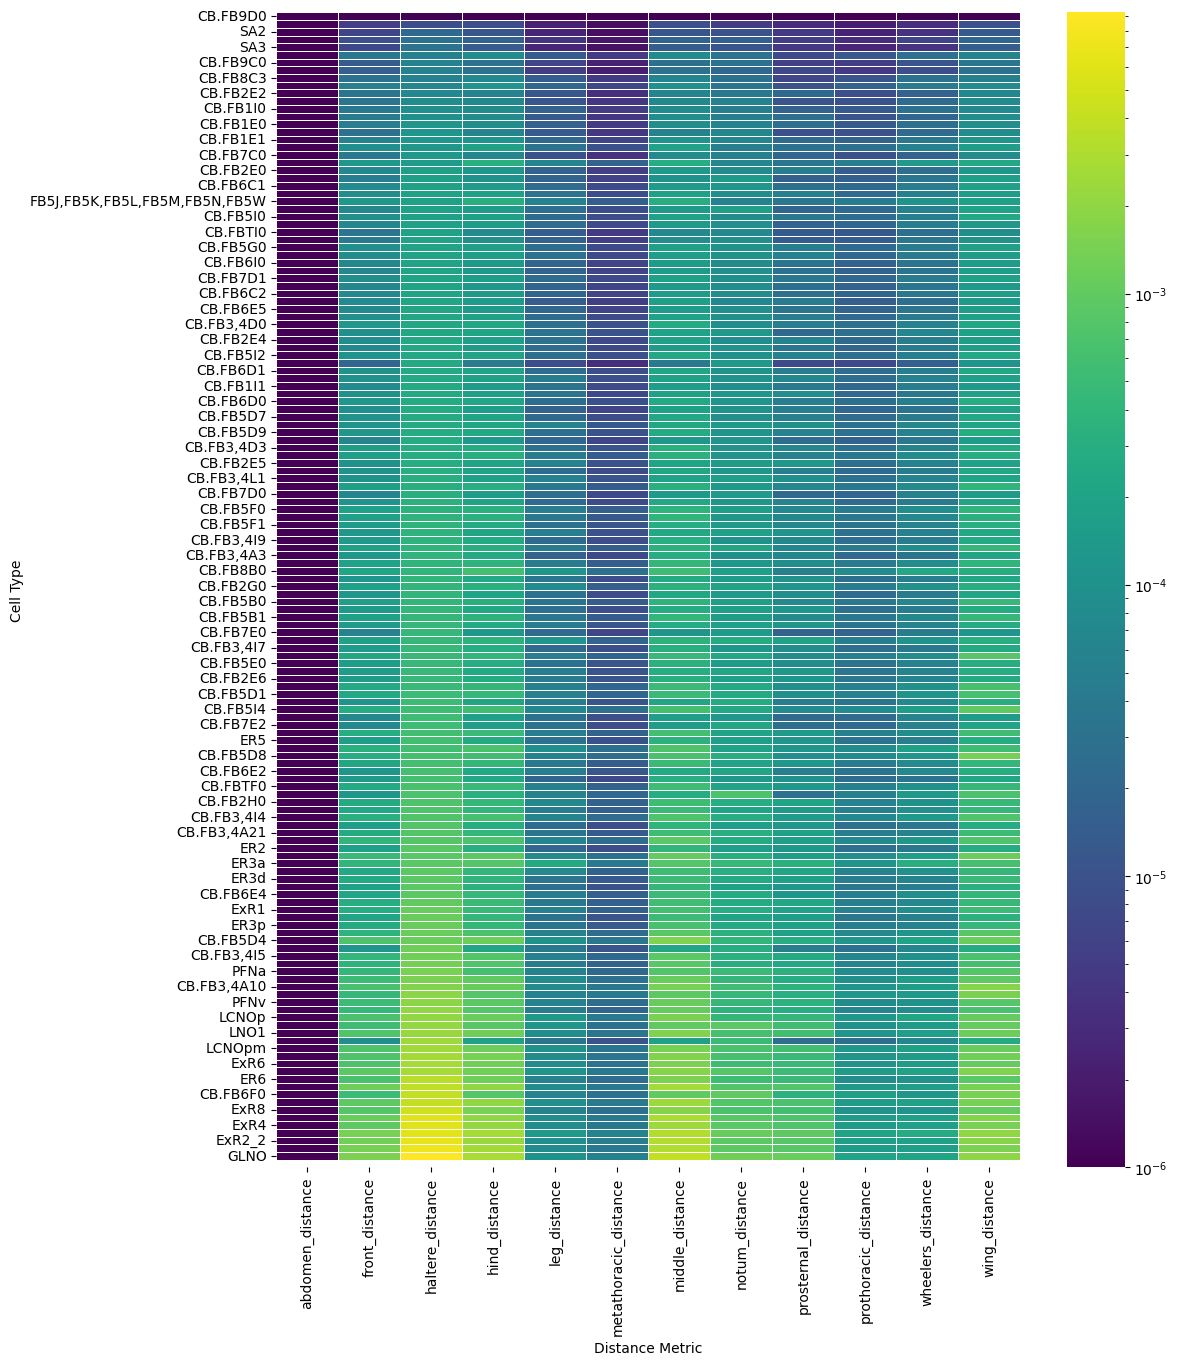

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot_neuron_distance_heatmap_log_sorted(distance_dict, sort_metric=None):
    """
    Plots a heatmap of distance values for neurons with a log10-scaled color bar,
    sorted by the specified metric. The figure size is adjusted based on the number
    of rows and columns to ensure a clear y-axis.

    Args:
        distance_dict (dict): Dictionary mapping cell_type to a list of (distance_column, distance_value) pairs.
        sort_metric (str, optional): The metric to sort by. If None or not found in the data,
                                     defaults to the first metric.
    """
    # Convert dictionary to a DataFrame
    heatmap_data = pd.DataFrame({
        cell_type: {col: value for col, value in distances}
        for cell_type, distances in distance_dict.items()
    }).T  # Transpose for proper alignment

    # Ensure all values are positive (for log10 scale)
    heatmap_data += 1e-6  

    # Determine the sorting metric
    if sort_metric is None or sort_metric not in heatmap_data.columns:
        sort_metric = heatmap_data.columns[0]
    # Sort by the specified metric
    heatmap_data = heatmap_data.sort_values(by=sort_metric, ascending=True)

    # Dynamically adjust figure size based on data dimensions:
    n_rows, n_cols = heatmap_data.shape
    fig_width = max(8, n_cols * 1.0)   # Adjust width scaling factor as needed
    fig_height = max(6, n_rows * 0.1)  # Adjust height scaling factor to prevent squeezing

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        heatmap_data, 
        cmap="viridis", 
        norm=mcolors.LogNorm(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max()), 
        annot=False,  # Only show colors
        linewidths=0.5
    )
    
    plt.xlabel("Distance Metric")
    plt.ylabel("Cell Type")
    # plt.title(f"Neuron Distance Heatmap (Sorted by {sort_metric}, Log10 Scale)")
    plt.show()

# Example call:
plot_neuron_distance_heatmap_log_sorted(result, sort_metric="haltere_distance")
